Adjust learning rate by GPUs in DataParallel

In [1]:
import os
import pickle

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import tqdm
from torch.nn import functional as fnn
from torch.utils import data
from torchvision import transforms

from hack_utils import ScaleMinSideToSize, CropCenter, TransformByKeys
from hack_utils import ThousandLandmarksDataset
from hack_utils import restore_landmarks_batch, create_submission
from hack_utils import stqdm

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_DIR = '../data/'
LOCAL_DATA_DIR = '/work/local_data/made_cv/contest1'

In [3]:
GPUs = [0, 1, 2]

In [4]:
NUM_PTS = 971
CROP_SIZE = 128
BATCH_SIZE = 512 * len(GPUs)
LR = 1e-3 * len(GPUs)
NUM_WORKERS = 24
MODEL_NAME = 'model_03'

In [5]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
def train(model, loader, loss_fn, optimizer, device):
    model.train()
    train_loss = []
    for batch in stqdm(loader, total=len(loader), desc="training...", leave=True):
        images = batch["image"].to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
        landmarks = batch["landmarks"]  # B x (2 * NUM_PTS)

        pred_landmarks = model(images).cpu()  # B x (2 * NUM_PTS)
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return np.mean(train_loss)

In [7]:
def validate(model, loader, loss_fn, device):
    model.eval()
    val_loss = []
    for batch in stqdm(loader, total=len(loader), desc="validation...", leave=True):
        images = batch["image"].to(device)
        landmarks = batch["landmarks"]

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        val_loss.append(loss.item())

    return np.mean(val_loss)

In [8]:
def predict(model, loader, device):
    model.eval()
    predictions = np.zeros((len(loader.dataset), NUM_PTS, 2))
    for i, batch in enumerate(stqdm(loader, total=len(loader), desc="test prediction...", leave=True)):
        images = batch["image"].to(device)

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        pred_landmarks = pred_landmarks.numpy().reshape((len(pred_landmarks), NUM_PTS, 2))  # B x NUM_PTS x 2

        fs = batch["scale_coef"].numpy()  # B
        margins_x = batch["crop_margin_x"].numpy()  # B
        margins_y = batch["crop_margin_y"].numpy()  # B
        prediction = restore_landmarks_batch(pred_landmarks, fs, margins_x, margins_y)  # B x NUM_PTS x 2
        predictions[i * loader.batch_size: (i + 1) * loader.batch_size] = prediction

    return predictions

In [9]:
train_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), ("image",)),
])

In [10]:
train_dataset = ThousandLandmarksDataset(os.path.join(LOCAL_DATA_DIR, 'train'), train_transforms, split="train")
train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True,
                                   shuffle=True, drop_last=True)

Total lines (without header): 393930
Loading train dataset (315144 lines)


In [11]:
val_dataset = ThousandLandmarksDataset(os.path.join(LOCAL_DATA_DIR, 'train'), train_transforms, split="val")
val_dataloader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True,
                                 shuffle=False, drop_last=False)

Total lines (without header): 393930
Loading val dataset (78786 lines)


In [12]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [13]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2 * NUM_PTS, bias=True)

model = nn.DataParallel(model, device_ids=GPUs)

model.to(device)

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [14]:
optimizer = optim.Adam(model.parameters(), lr=LR, amsgrad=True)
loss_fn = fnn.mse_loss

In [15]:
N_EPOCHS = 10
best_val_loss = np.inf
for epoch in range(N_EPOCHS):
    train_loss = train(model, train_dataloader, loss_fn, optimizer, device=device)
    val_loss = validate(model, val_dataloader, loss_fn, device=device)
    print("Epoch #{:2}:\ttrain loss: {:.5f}\tval loss: {:.5f}".format(epoch, train_loss, val_loss))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        with open(os.path.join(DATA_DIR, f"{MODEL_NAME}_best.pth"), "wb") as fp:
            torch.save(model.state_dict(), fp)


Epoch # 0:	train loss: 322.29982	val loss: 69.62033



Epoch # 1:	train loss: 20.84285	val loss: 20.46248



Epoch # 2:	train loss: 11.68319	val loss: 6.26213



Epoch # 3:	train loss: 5.39239	val loss: 5.30863



Epoch # 4:	train loss: 4.15189	val loss: 3.76290



Epoch # 5:	train loss: 3.51062	val loss: 3.43357



Epoch # 6:	train loss: 3.15482	val loss: 3.12540



Epoch # 7:	train loss: 2.90324	val loss: 2.89020



Epoch # 8:	train loss: 2.71272	val loss: 2.70762



Epoch # 9:	train loss: 2.49992	val loss: 2.57407


In [16]:
with open(os.path.join(DATA_DIR, f"{MODEL_NAME}_best.pth"), "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

In [17]:
test_dataset = ThousandLandmarksDataset(os.path.join(LOCAL_DATA_DIR, 'test'), train_transforms, split="test")
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True,
                                  shuffle=False, drop_last=False)

Total lines (without header): 99819


In [18]:
test_predictions = predict(model, test_dataloader, device)
with open(os.path.join(DATA_DIR, f"{MODEL_NAME}_test_predictions.pkl"), "wb") as fp:
    pickle.dump({"image_names": test_dataset.image_names,
                 "landmarks": test_predictions}, fp)

In [19]:
create_submission(DATA_DIR, test_predictions,
                 os.path.join(DATA_DIR, f"{MODEL_NAME}_submit.csv"))

In [20]:
TEST_PREDICTIONS_FILENAME = os.path.join(DATA_DIR, f"{MODEL_NAME}_test_predictions.pkl")
NUM_IMAGES_TO_SHOW = 16
NUM_COLS = 4
NUM_ROWS = NUM_IMAGES_TO_SHOW // NUM_COLS + int(NUM_IMAGES_TO_SHOW % NUM_COLS != 0)

In [21]:
def draw_landmarks(image, landmarks):
    for point in landmarks:
        x, y = point.astype(np.int)
        cv2.circle(image, (x, y), 1, (128, 0, 128), 1, -1)
    return image

In [22]:
with open(TEST_PREDICTIONS_FILENAME, "rb") as fp:
    results = pickle.load(fp)
image_names = results["image_names"]
landmarks = results["landmarks"]

print("Images:", len(image_names))
print("Landmarks shape:", landmarks.shape)

if len(image_names) < NUM_IMAGES_TO_SHOW:
    raise RuntimeError(f"Choose less images to show, you have only {len(image_names)}")

Images: 99819
Landmarks shape: (99819, 971, 2)


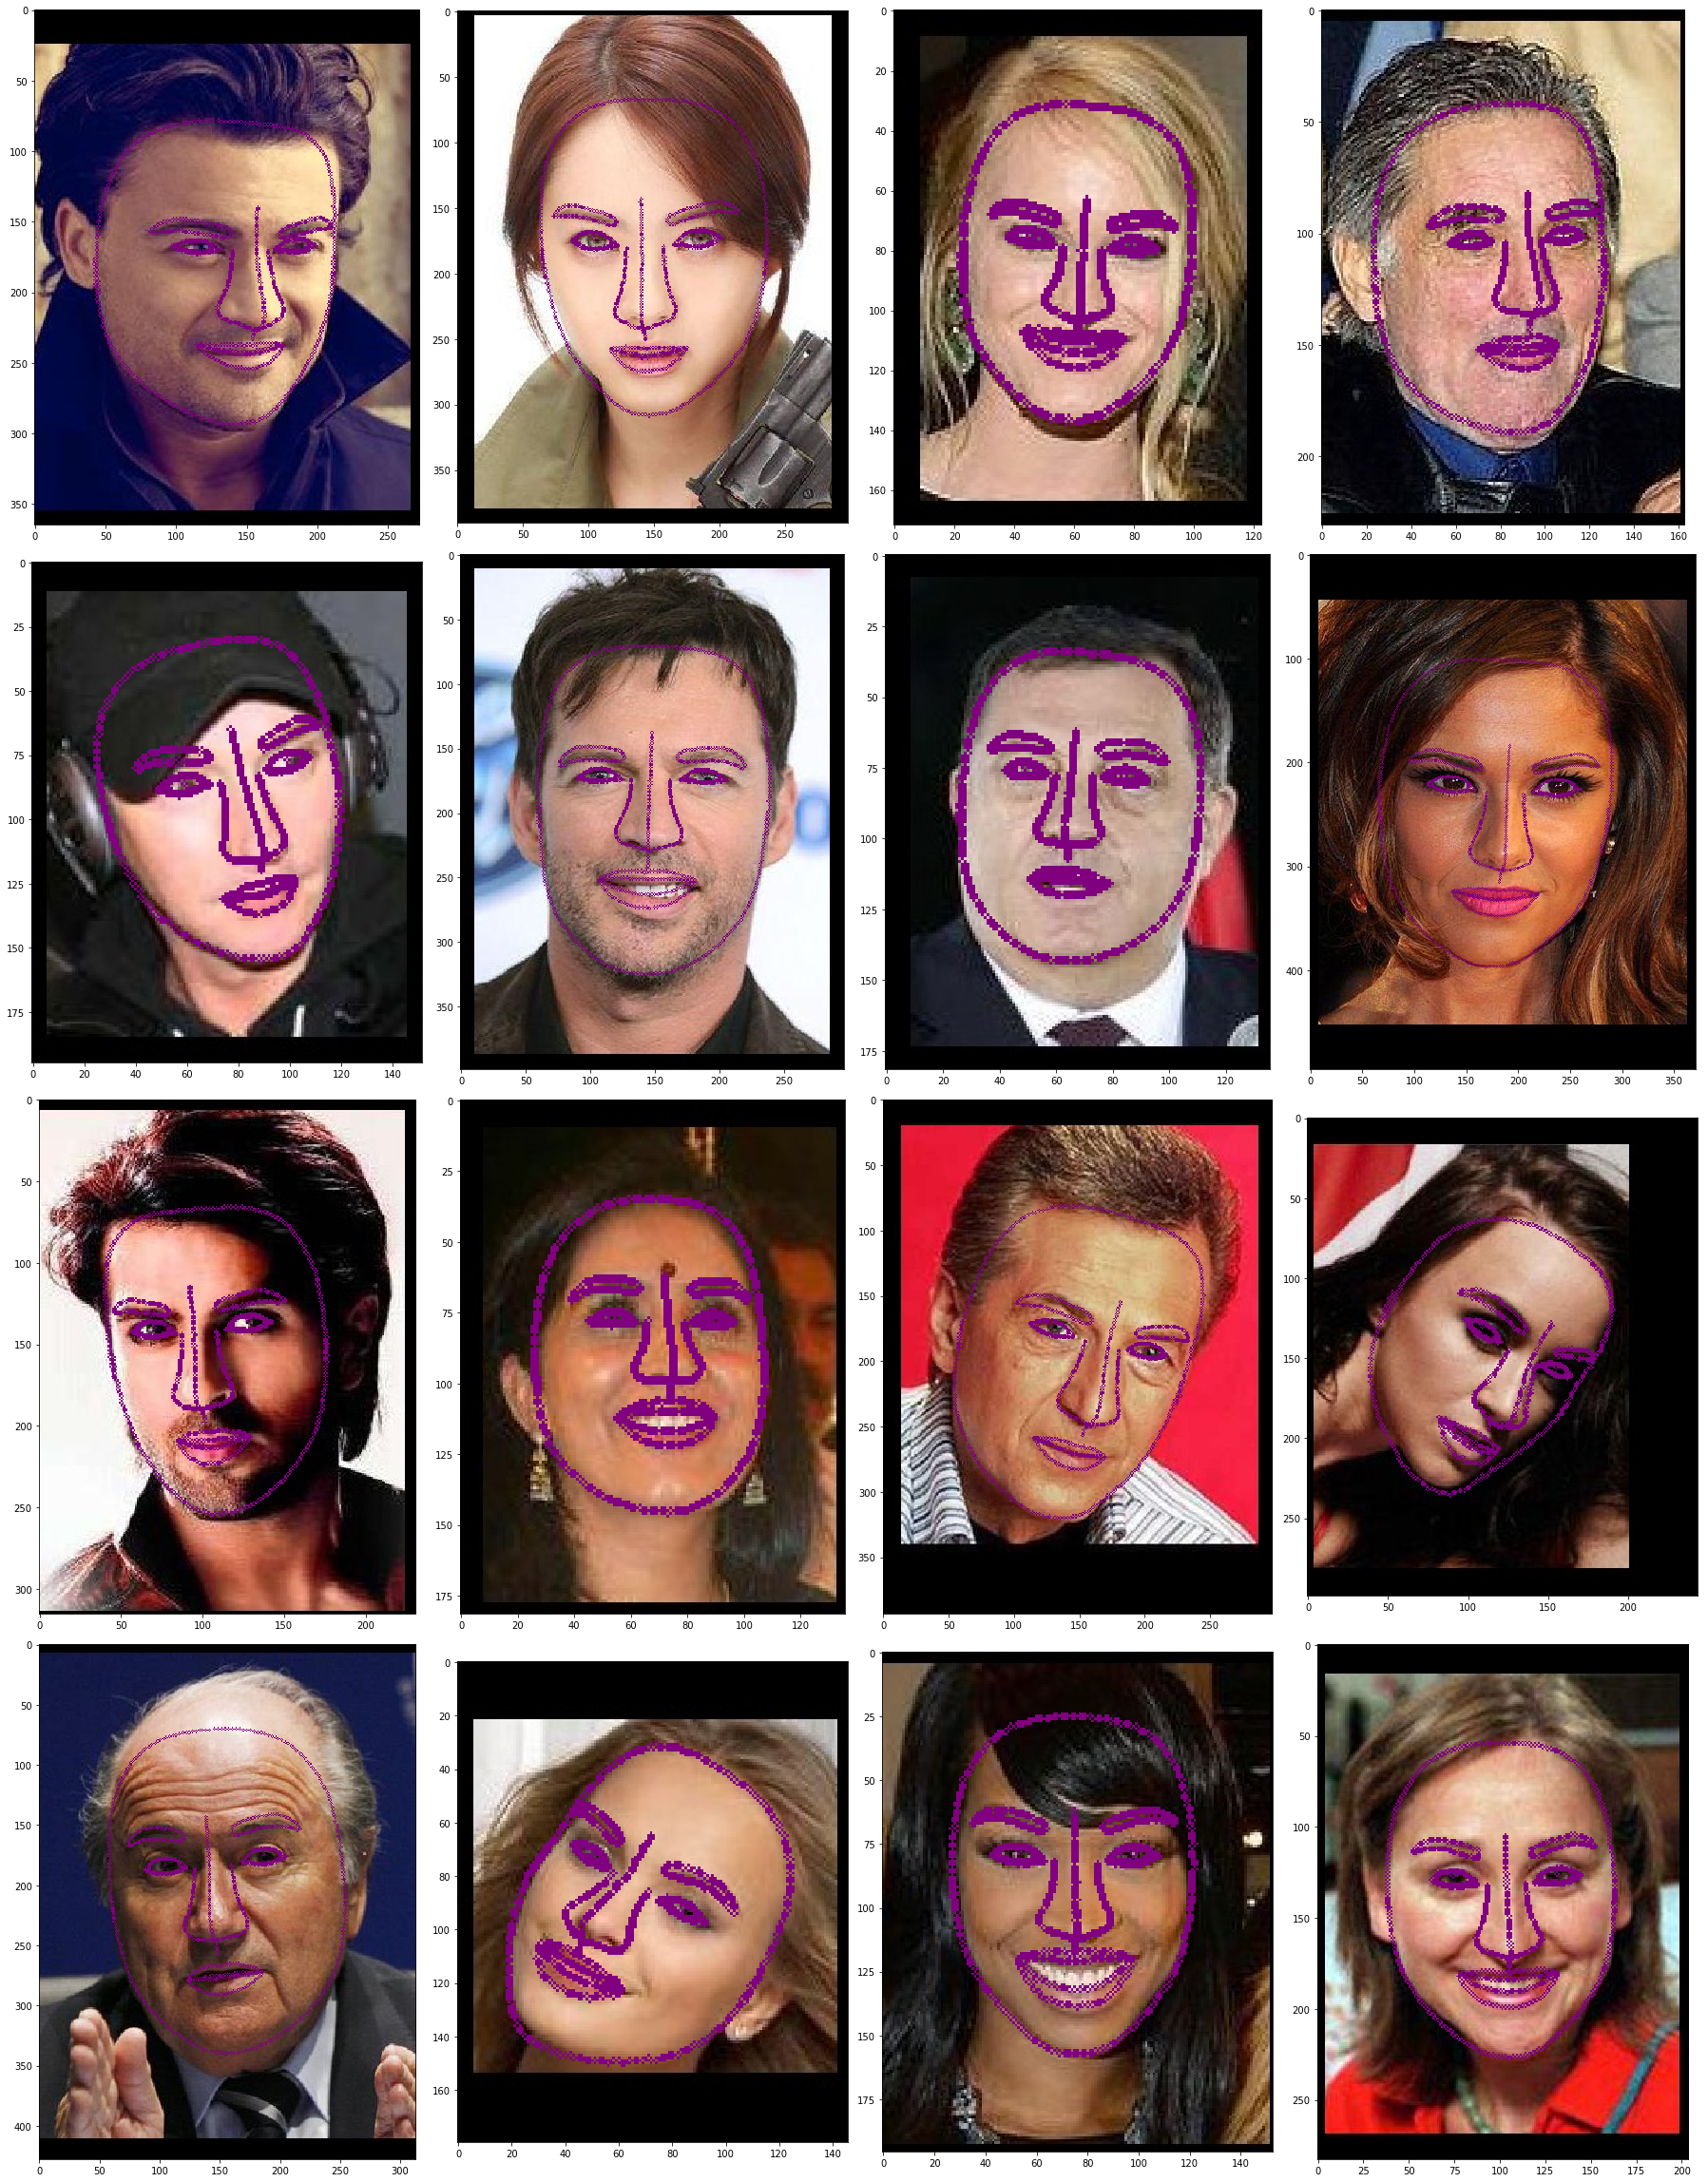

In [23]:
random_idxs = np.random.choice(len(image_names), size=min(NUM_IMAGES_TO_SHOW, len(image_names)), replace=False)

plt.figure(figsize=(25, NUM_ROWS * 8))
for i, idx in enumerate(random_idxs, 1):
    image = cv2.imread(image_names[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = draw_landmarks(image, landmarks[idx])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image)

plt.tight_layout()
plt.show()